In [1]:
import cv2 as cv
import watershedOpenCV as wa
import customAlgorithm as ca

loadableVideos = {"Toucan" : 1, "Dino" : 2, "Cracker" : 3, "Ganesh" : 4}

# Variables to set to choose the algorithm and the video to load
videoToLoad = loadableVideos["Ganesh"]  # Choose one among the keys in loadableVideos
chosenAlgorithm = "watershed" # "custom" or "watershed"

# Open the video reader and read the first frame, if available
videoReader = cv.VideoCapture("../data/obj0" + str(videoToLoad) + ".mp4")
success, image = videoReader.read()

# Choose the algorithm for the execution.
algorithm = wa.watershedSegmentation if chosenAlgorithm == "watershed" else ca.multiSpaceSegmentation

# Set the video format to mp4, as for the original videos
videoFormat = cv.VideoWriter_fourcc("m", "p", "4", "v")

# Start an OpenCV videowriter to write the frames on the new video.
# I always set the 29.97 fps and 1920x1080 for each video because every original video has such parameters.
videoWriter = cv.VideoWriter("../data/obj0" + str(videoToLoad) + "_mask.mp4", videoFormat, 29.97, (1920, 1080))

while (success and videoReader.isOpened()):
    """Transform the frame just read and save it at the same time as new frame for the 
    new video.
    """
    videoWriter.write(algorithm(image))
    success, image = videoReader.read()

videoWriter.release()
videoReader.release()
cv.destroyAllWindows()

Now I compare the results of the two methods I built against the ground truth masks:

In [2]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
)
import cv2 as cv
import watershedOpenCV as wa
import customAlgorithm as ca
from os import listdir
from numpy import array

from copy import deepcopy

"""cv2, watershedOpenCV and customAlgorithm are imported again to allows the execution 
of just the performance examination chunk.
"""

# Retrieve every test frame (both ground truth and frames to transform)
testDataset = [
    cv.imread("../assignment1_test_dataset/obj0" + str(videoIndex) + "/" + fileName)
    for videoIndex in [1, 2, 4]
    for fileName in listdir("../assignment1_test_dataset/obj0" + str(videoIndex) + "/")
]

# This binarization is necessary because groundTruthTestMasks images include also other values
# than 255 and 0.
def binarizeIntensityFrame(frame):
    frame[frame != 0] = 255
    return frame

# Store the ground trouth frames
groundTruthTestMasks = testDataset[1::2]
# Compute the "multi-space" and watershed segmented images. The deepcopy was necessary
# otherwise multiSpaceSegmentation would have modified testDataset, and hence compromised
# the results of watershedSegmentation.
customComputedTestMasks = [ca.multiSpaceSegmentation(rawTestFrame) for rawTestFrame in deepcopy(testDataset[0::2])]
watershedComputedTestMasks = [wa.watershedSegmentation(rawTestFrame) for rawTestFrame in deepcopy(testDataset[0::2])]

# Convert the 3 sets of images to gray scale with 2 values (0 and 255), to have an
# easier correspondence with Negative and Positive classes.
for index in range(len(groundTruthTestMasks)):
    groundTruthTestMasks[index] = binarizeIntensityFrame(cv.cvtColor(groundTruthTestMasks[index], cv.COLOR_BGR2GRAY))
    watershedComputedTestMasks[index] = cv.cvtColor(watershedComputedTestMasks[index], cv.COLOR_BGR2GRAY)
    customComputedTestMasks[index] = cv.cvtColor(customComputedTestMasks[index], cv.COLOR_BGR2GRAY)

# Linearize the arrays to compare them pixel by pixel.
groundTruthTestMasks = array(groundTruthTestMasks).ravel()
watershedComputedTestMasks = array(watershedComputedTestMasks).ravel()
customComputedTestMasks = array(customComputedTestMasks).ravel()

watershedAccuracy = accuracy_score(groundTruthTestMasks, watershedComputedTestMasks)
customAccuracy = accuracy_score(groundTruthTestMasks, customComputedTestMasks)

print(f"WatershedOpenCV segmentation achieves an accuracy of {watershedAccuracy}.")
print(f"Multi space segmentation achieves an accuracy of {customAccuracy}.\n")

watershedPrecision = precision_score(groundTruthTestMasks, watershedComputedTestMasks, pos_label=255)
customPrecision = precision_score(groundTruthTestMasks, customComputedTestMasks, pos_label=255)

print(f"WatershedOpenCV segmentation achieves a precision of {watershedPrecision}.")
print(f"Multi space segmentation achieves a precision of {customPrecision}.\n")

watershedRecall = recall_score(groundTruthTestMasks, watershedComputedTestMasks, pos_label=255)
customRecall = recall_score(groundTruthTestMasks, customComputedTestMasks, pos_label=255)

print(f"WatershedOpenCV segmentation achieves a recall of {watershedRecall}.")
print(f"Multi space segmentation achieves a recall of {customRecall}.\n")

WatershedOpenCV segmentation achieves an accuracy of 0.9792389724794238.
Multi space segmentation achieves an accuracy of 0.9962096514917695.

WatershedOpenCV segmentation achieves a precision of 0.9924746044098574.
Multi space segmentation achieves a precision of 0.9936587544571787.

WatershedOpenCV segmentation achieves a recall of 0.9639245673144333.
Multi space segmentation achieves a recall of 0.998451132435567.



I print, as requested, the following scores: 
 - The accuracy which is the accuracy of the classification of each pixel. 

 - The precision which is the ability of the classifier not to label as positive a sample that is negative.It is calculated as follows: 
    tp/(tp + fp) where tp is the number of true positives and fp the number of false positives.

 - The recall which is the ability of the classifier to find all the positive samples. It it computed as follows: 
   tp / (tp + fn) where tp is the number of true positives and fn the number of false 
   negatives.
   
 In my case I got that on average the "multiSpace" algorithm scores better than the watershed algorithm of OpenCv, in particular I got that: 
 - The precision is very similar and high for both methods. 
 - The recall and accuracy performs a few points better in the "multiSpace" algorithm, although they score very well also with watershed. 

Now let's focus on the confusion matrices related to the two methods. First we give a look to the Watershed matrix:

In [3]:
watershedCf = confusion_matrix(groundTruthTestMasks, watershedComputedTestMasks)
customCf = confusion_matrix(groundTruthTestMasks, customComputedTestMasks)

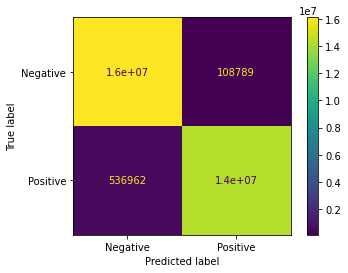

In [4]:
import matplotlib.pyplot as plt

watershedCfDisplay = ConfusionMatrixDisplay(
    watershedCf, display_labels=["Negative", "Positive"]
)

watershedCfDisplay.plot()
plt.show()

Now we are going to see the Custom Algorithm's confusion matrix: 

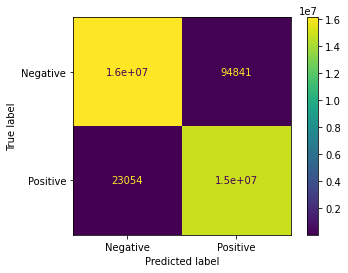

In [5]:
customCfDisplay = ConfusionMatrixDisplay(
    customCf, display_labels=["Negative", "Positive"]
)

customCfDisplay.plot()
plt.show()

As we can see in the both matrices above, we have a good balance, since we have that:
 - The true positive (tp), which refers to a sample correctly classified positive, 
   and the true negative (tn), which refers to a sample correctly classified as negative, both have a high value. 
 - Instead, as expected, both false positives (fp) and false negatives (fn) have low values. 

In particular, we have that:
 - the customAlgorithm has a much better confusion matrix than the watershedOpenCv. 
 - tp of customAlgorithm's confusion matrix are around 1.5e+07 against 1.4e+07 of watershedOpenCv's confusion matrix.
 - tn of customAlgorithm's confusion matrix are the same as those of watershedOpenCv's confusion matrix, that is, 1.6e+07.
 - fp of customAlgorithm's confusion matrix are around 94841 versus 108789 of watershedOpenCv's confusion matrix.
 - fn of customAlgorithm's confusion matrix are around 23054 against 536962 of watershedOpenCv's confusion matrix.